In [2]:
using Distributed
addprocs(5)
@everywhere using DrWatson
@everywhere @quickactivate "Qwind"
using Qwind
include("../../scripts/plotting.jl")

      From worker 6:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 4:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 2:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 5:	  Activating environment at `~/code/Qwind.jl/Project.toml`
      From worker 3:	  Activating environment at `~/code/Qwind.jl/Project.toml`


┌ Info: Precompiling Qwind [988db7c6-b368-4d8d-9ee1-ae26d5771fb3]
└ @ Base loading.jl:1313


Main.QwindPlotting

In [4]:
model = Model("./config.yaml");
try
    rm(model.config[:integrator][:save_path], recursive=true)
catch
end
iterations_dict = Dict();
run!(model, iterations_dict);

┌ Info: Saving results to ./data
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:103
┌ Info: Iterating streamlines...
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:76
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21
┌ Info: Integration of iteration 1 ended!
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:80
┌ Info: Saving results...
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:81
┌ Info: Done
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:84
┌ Info: Wind properties
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:86
┌ Info: Mass loss fraction 0.0
└ @ Qwind /home/arnau/code/Qwind.jl/src/model.jl:87
┌ Info: Updating radiative transfer... 
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/regular_grid.jl:37
┌ Info: Constructing wind hull...
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/base.jl:37
┌ Info: Getting dense solution from integrators...
└ @ Qwind /home/arnau/code/Qwind.jl/src/integrator.jl:449
┌ Info: Done

In [231]:
using PyPlot, ColorSchemes, Colors, PyCall
include("../../scripts/plotting.jl")
include("./style.jl")
mnras_width = 252/72.27
dpi=350
cmap = colorschemes[:dense]
cmap_pl = ColorMap("cmap", cmap.colors)
Normalize = matplotlib.colors.Normalize
rcParams = PyDict(matplotlib["rcParams"])
rcParams["figure.dpi"] = 250

250

# Reduce integrators

In [75]:
integrators = iterations_dict[5]["integrators"];
integrators_reduced = Qwind.reduce_integrators_individual(integrators);
integrators_reduced_merged = Qwind.reduce_integrators(integrators);

┌ Info: Reducing integrators...
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/integrators_interpolator.jl:87
┌ Info: Done
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/integrators_interpolator.jl:105


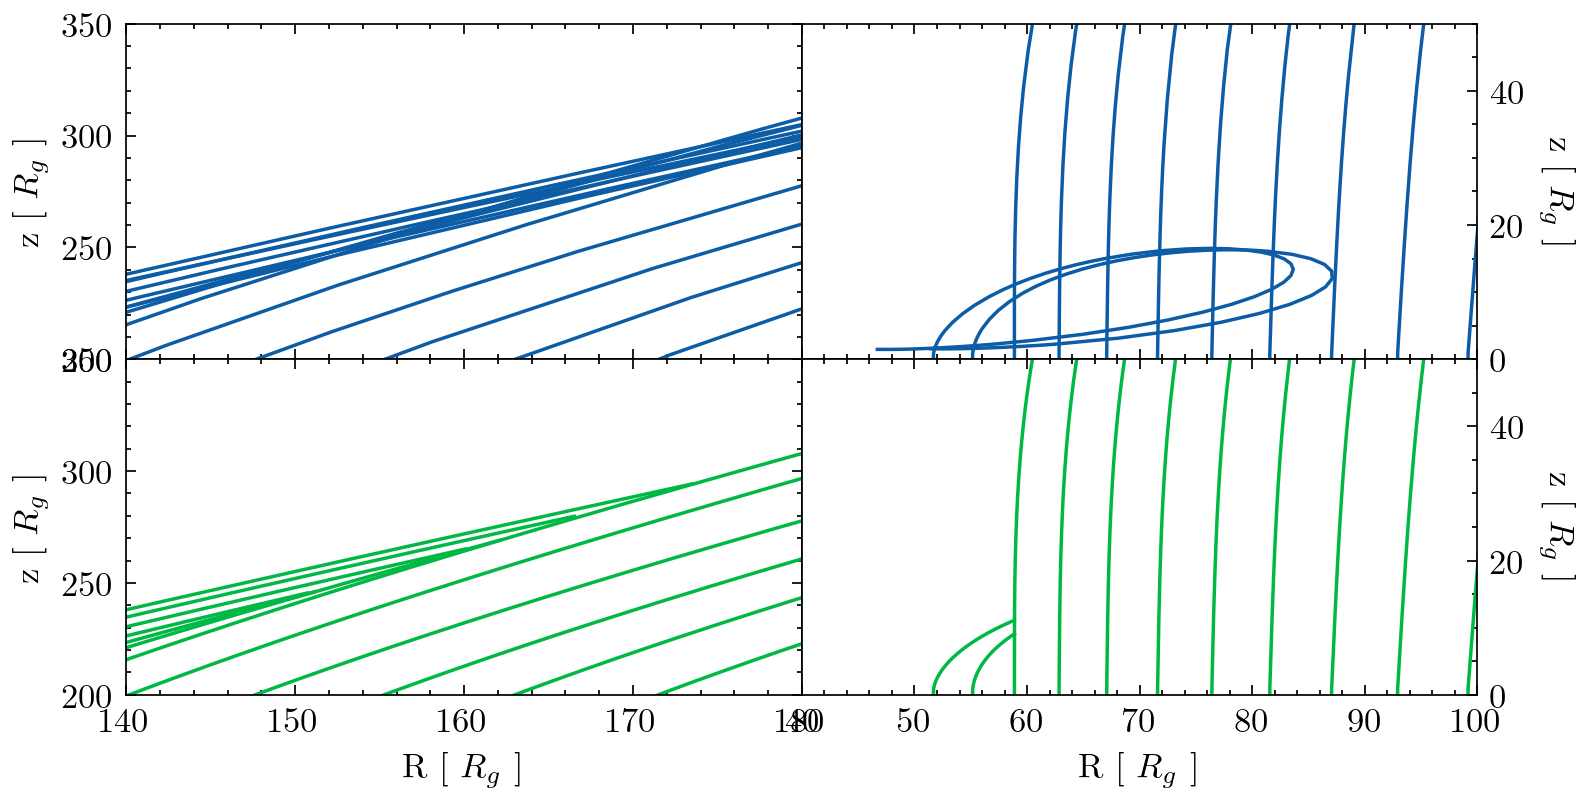

In [236]:
fig, ax = plt.subplots(2, 2, figsize=(2 * mnras_width, mnras_width))
for (integ, integ_reduced) in zip(integrators, integrators_reduced)
    ax[1,1].plot(integ.p.data[:r], integ.p.data[:z], color = "C0")
    ax[2,1].plot(integ_reduced.r, integ_reduced.z, color = "C1")
    
    ax[1,2].plot(integ.p.data[:r], integ.p.data[:z], color = "C0")
    ax[2,2].plot(integ_reduced.r, integ_reduced.z, color = "C1")
end

ax[1,1].set_xlim(140,180)
ax[2,1].set_xlim(140,180)

ax[1,1].set_ylim(200,350)
ax[2,1].set_ylim(200,350)

ax[1,2].set_xlim(40, 100)
ax[2,2].set_xlim(40, 100)
ax[1,2].set_ylim(0,50)
ax[2,2].set_ylim(0,50)

ax[1,1].set_ylabel(L"z [ $R_g$ ]")
ax[2,1].set_ylabel(L"z [ $R_g$ ]")
ax[2,1].set_xlabel(L"R [ $R_g$ ]")
ax[2,2].set_xlabel(L"R [ $R_g$ ]")

ax[1,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[1,2].yaxis.set_label_position("right")
ax[2,2].yaxis.set_label_position("right")


ax[1,2].yaxis.tick_right()
ax[2,2].yaxis.tick_right()

ax[1,1].set_xticklabels([])
ax[1,2].set_xticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)


In [79]:
r, z, vr, vz, n = integrators_reduced_merged;
hull = construct_wind_hull(integrators);
r0 = [integ.p.r0 for integ in integrators];

In [140]:
function get_density_grid(r, z, n, r0, hull; rmin=1, rmax=1000, zmin=1e-6, zmax=1000, interpolation_type="nn", nr=250, nz=250)
    interpolator = Qwind.get_density_interpolator(r, z, n, type=interpolation_type)
    r_range = collect(range(rmin, rmax, length=nr))
    z_range = collect(range(zmin, zmax, length=nz))
    r_range_log = log10.(r_range)
    z_range_log = log10.(z_range)
    density_grid = 1e2 .* ones((length(r_range), length(z_range)))
    for (i, r) in enumerate(r_range)
        for (j, z) in enumerate(z_range)
            point = [r, z]
            if !Qwind.is_point_in_wind(hull, point)
                density_grid[i, j] = 1e2
            else
                density_grid[i, j] = 10 .^ interpolator(log10(r), log10(z))[1]
            end
        end
    end
    # add z = 0 line
    density_grid = [density_grid[:, 1] density_grid]
    pushfirst!(z_range, 0.0)
    grid = DensityGrid(r_range, z_range, density_grid, nr, nz)
    return grid
end

function get_velocity_grid(r, z, vr, vz, r0, hull; rmin=1, rmax=1000, zmin=1e-6, zmax=1000, interpolation_type="nn", nr=250, nz=250)
    vr_interp, vz_interp = Qwind.get_velocity_interpolators(r, z, vr, vz, type=interpolation_type)
    r_range = collect(range(rmin, rmax, length=nr))
    z_range = collect(range(zmin, zmax, length=nz))
    r_range_log = log10.(r_range)
    z_range_log = log10.(z_range)
    vr_grid = zeros((length(r_range), length(z_range)))
    vz_grid = zeros((length(r_range), length(z_range)))
    for (i, r) in enumerate(r_range)
        for (j, z) in enumerate(z_range)
            point = [r, z]
            if !Qwind.is_point_in_wind(hull, point)
                continue
            else
                vr_grid[i,j] = vr_interp(log10(r), log10(z))[1]
                vz_grid[i,j] = vz_interp(log10(r), log10(z))[1]
            end
        end
    end
    # add z = 0 line
    vr_grid = [vr_grid[:,1] vr_grid]
    vz_grid = [vz_grid[:,1] vz_grid]
    pushfirst!(z_range, 0.0)
    grid = VelocityGrid(r_range, z_range, vr_grid, vz_grid, nr, nz)
    @info "Done"
    return grid

end


get_velocity_grid (generic function with 2 methods)

In [158]:
density_grid_nn = get_density_grid(r, z, n, r0, hull, rmin=50, rmax=60, zmin=1, zmax=20, interpolation_type="nn");
density_grid_linear = get_density_grid(r, z, n, r0, hull, rmin=50, rmax=60, zmin=1, zmax=20, interpolation_type="linear");

In [159]:
velocity_grid_nn = get_velocity_grid(r, z, vr, vz, r0, hull, rmin=50, rmax=60, zmin=1, zmax=20, interpolation_type="nn");
velocity_grid_linear = get_velocity_grid(r, z, vr, vz, r0, hull, rmin=50, rmax=60, zmin=1, zmax=20, interpolation_type="linear");

┌ Info: Done
└ @ Main In[140]:49
┌ Info: Done
└ @ Main In[140]:49


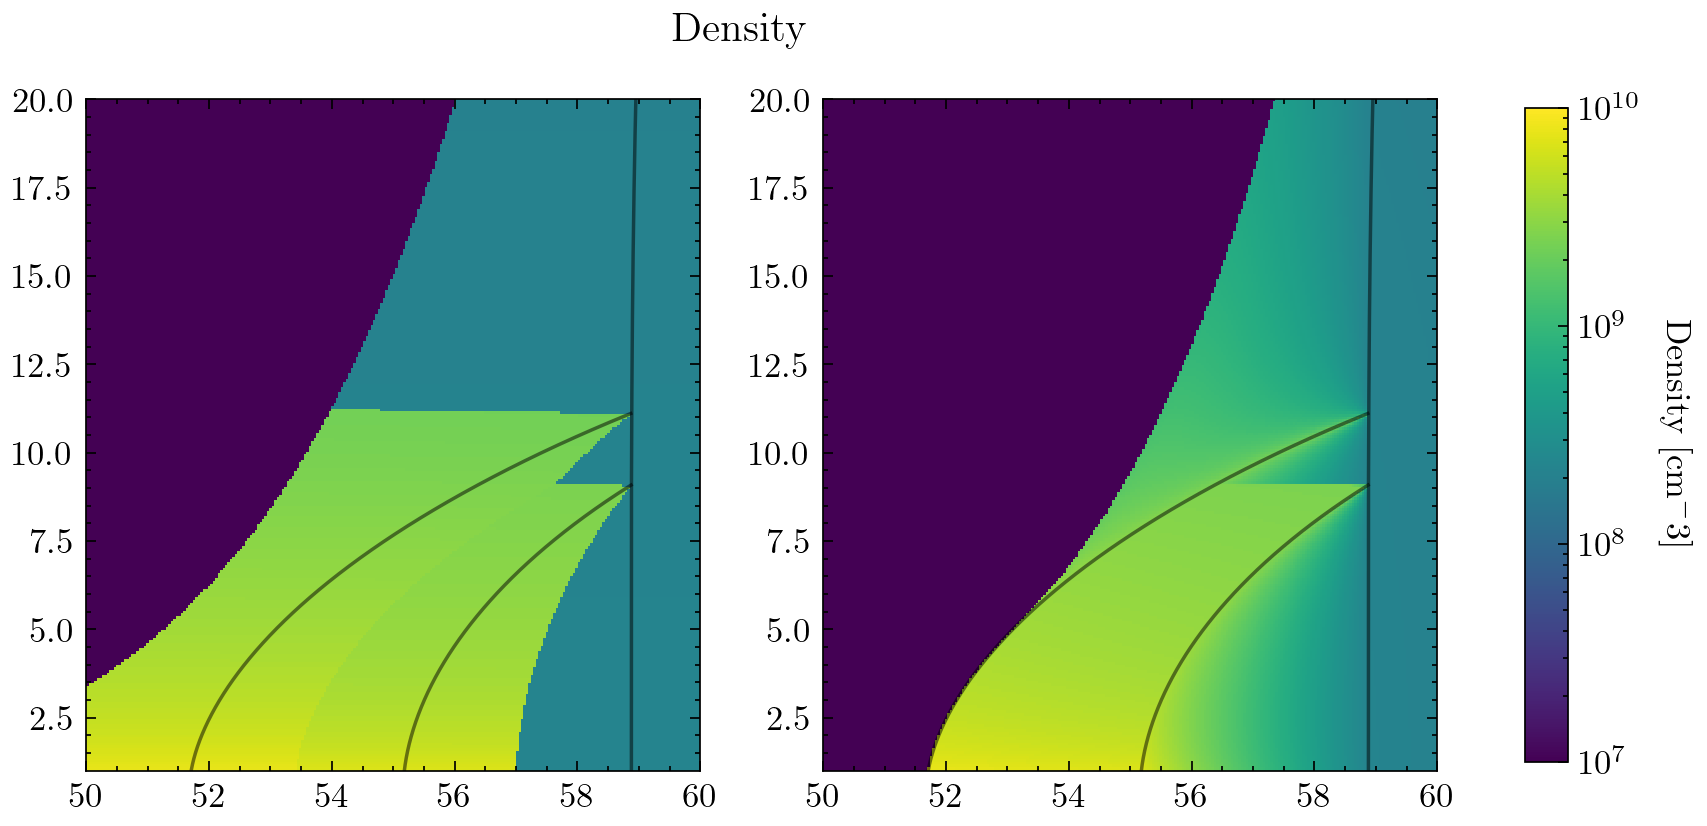

PyObject Text(0.5, 0.98, 'Density')

In [234]:
fig, ax = plt.subplots(1, 2, figsize=(2*mnras_width, mnras_width))
cm = ax[1].pcolormesh(density_grid_nn.r_range, density_grid_nn.z_range, density_grid_nn.grid', norm=LogNorm(vmin=1e7, vmax=1e10), shading="auto")
cm = ax[2].pcolormesh(density_grid_linear.r_range, density_grid_linear.z_range, density_grid_linear.grid', norm=LogNorm(vmin=1e7, vmax=1e10), shading="auto")

for integ_reduced in integrators_reduced
    ax[1].plot(integ_reduced.r, integ_reduced.z, color = "black", alpha=0.5)
    ax[2].plot(integ_reduced.r, integ_reduced.z, color = "black", alpha=0.5)
end

cbar_ax = fig.add_axes([0.95, 0.12, 0.025, 0.75])
cbar = fig.colorbar(cm, cax=cbar_ax)
cbar.set_label(L"Density [cm$^-3$]", rotation=-90, labelpad=15)

for axis in ax
    axis.set_xlim(50, 60)
    axis.set_ylim(1, 20)
end
fig.suptitle("Density")

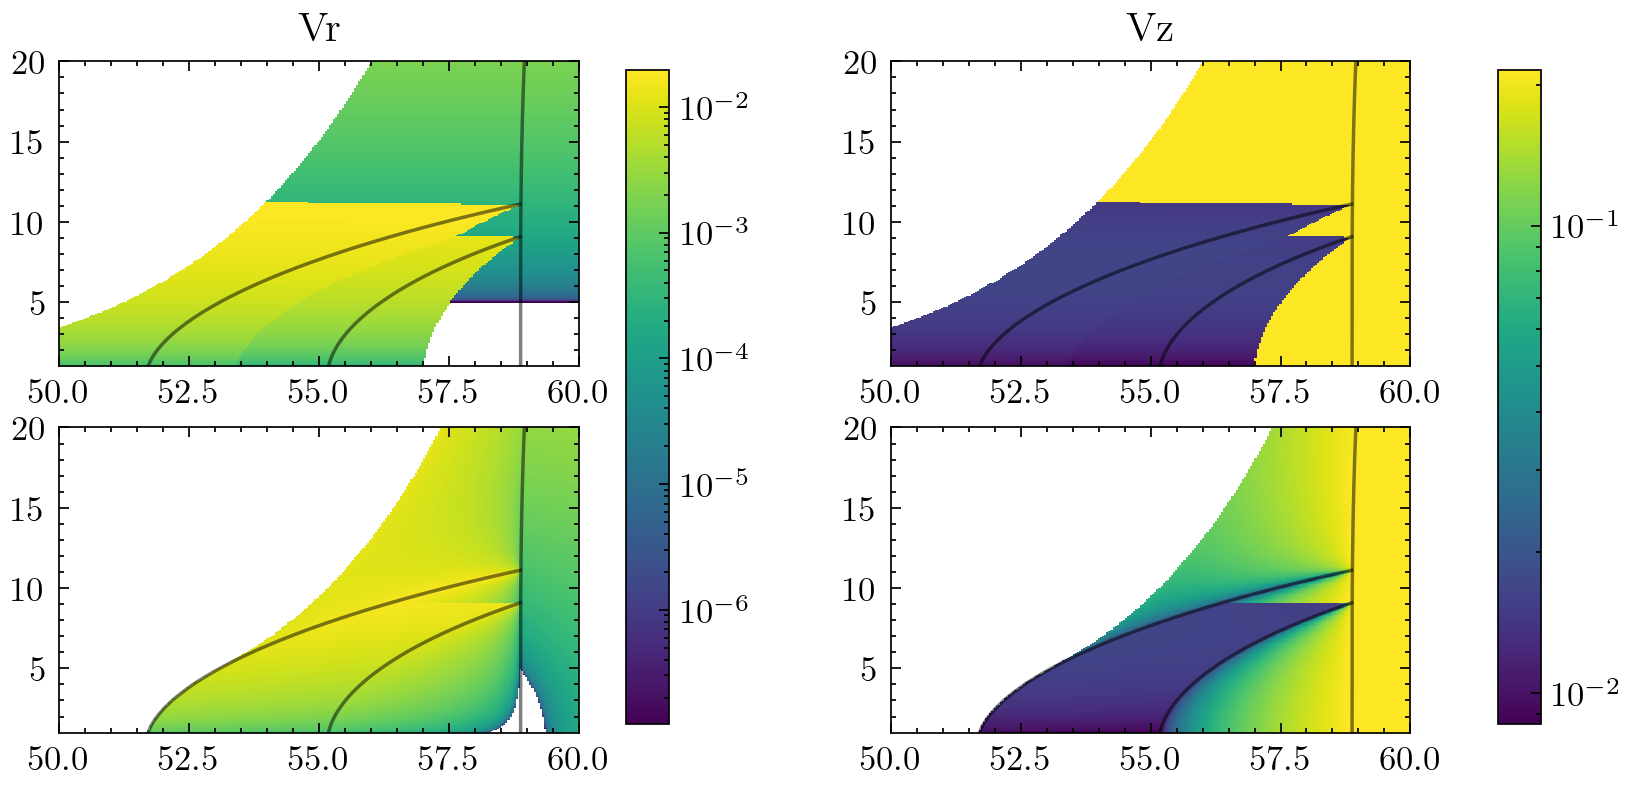

In [235]:
fig, ax = plt.subplots(2, 2, figsize=(2*mnras_width, mnras_width))
cm1 = ax[1,1].pcolormesh(velocity_grid_nn.r_range, velocity_grid_nn.z_range, velocity_grid_nn.vr_grid', norm=LogNorm(), shading="auto")
cm1 = ax[2,1].pcolormesh(velocity_grid_linear.r_range, velocity_grid_linear.z_range, velocity_grid_linear.vr_grid', norm=LogNorm(),shading="auto")
cm2 = ax[1,2].pcolormesh(velocity_grid_nn.r_range, velocity_grid_nn.z_range, velocity_grid_nn.vz_grid', norm=LogNorm(),shading="auto" )
cm2 = ax[2,2].pcolormesh(velocity_grid_linear.r_range, velocity_grid_linear.z_range, velocity_grid_linear.vz_grid', norm=LogNorm(),shading="auto" )

for axis in ax
    for integ_reduced in integrators_reduced
        axis.plot(integ_reduced.r, integ_reduced.z, color = "black", alpha=0.5)
    end
end

ax[1,1].set_title("Vr")
ax[1,2].set_title("Vz")

cbar_ax = fig.add_axes([0.45, 0.12, 0.025, 0.75])
cbar = fig.colorbar(cm1, cax=cbar_ax)

cbar_ax = fig.add_axes([0.95, 0.12, 0.025, 0.75])
cbar = fig.colorbar(cm2, cax=cbar_ax)


for axis in ax
    axis.set_xlim(50, 60)
    axis.set_ylim(1, 20)
end
plt.subplots_adjust(wspace=0.6)

# Wind Hull

In [8]:
hull1 = iterations_dict[2]["radiative_transfer"].interpolator.wind_hull
hull2 = iterations_dict[3]["radiative_transfer"].interpolator.wind_hull
integ1 = iterations_dict[1]["integrators"]
integ2 = iterations_dict[2]["integrators"];

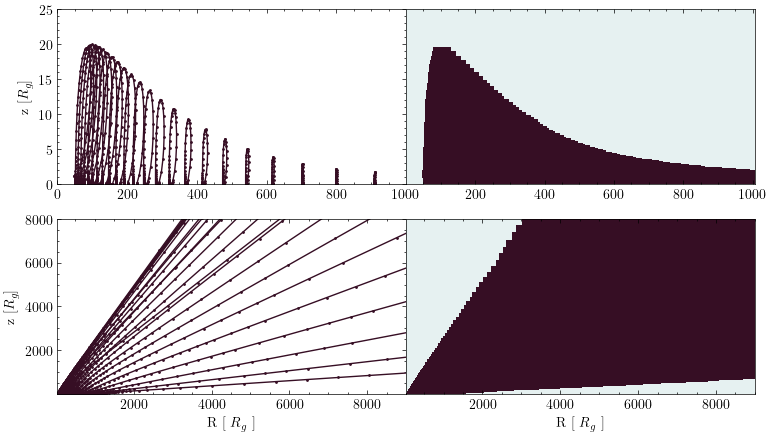

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(9,5))

QwindPlotting.plot_streamlines(integ1[1:2:end], fig=fig, ax=ax[1,1], color = "#" * hex(convert(RGB, get(cmap, 1))))
QwindPlotting.plot_wind_hull(hull1, fig=fig, ax=ax[1,2], zmax=25, nr=500, nz=500, cmap=cmap_pl)

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, ax=ax[2,1], color = "#" * hex(convert(RGB, get(cmap, 1))))
QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,2], rmax=10000, zmax=10000, nr=500, nz=500, cmap=cmap_pl)

ax[1,1].set_xlim(0,1000)
ax[1,1].set_ylim(0,25)
ax[1,1].set_xlabel("")

ax[2,1].set_xlim(40, 9000)
ax[2,1].set_ylim(1e-6, 8000)
ax[2,2].set_xlim(40, 9000)
ax[2,2].set_ylim(1e-6, 8000)

ax[2,2].yaxis.set_ticks([])
ax[1,2].yaxis.set_ticks([])

ax[2,2].set_xlabel(L"R [ $R_g$ ]")
ax[2,1].set_xlabel(L"R [ $R_g$ ]")

plt.subplots_adjust(wspace=0)
#fig.savefig("plots/wind_hull.pdf")

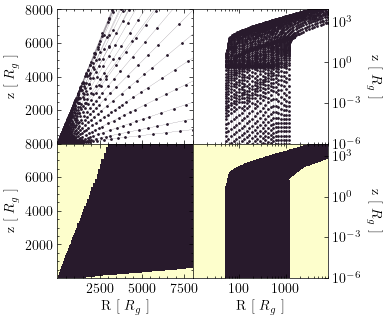

In [159]:
fig, ax = plt.subplots(2, 2, figsize=(mnras_width, mnras_width))#, figsize=(4,6))

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, linewidth=0.1, ax=ax[1,1], color = "#" * hex(convert(RGB, get(cmap, 1))))
QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,1], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl)

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, ax=ax[1,2], linewidth=0.1, color = "#" * hex(convert(RGB, get(cmap, 1))))
QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,2], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl)

ax[1,1].set_xlim(10,8000)
ax[1,1].set_ylim(1e-6, 8000)
#ax[1,1].set_xscale("log")
#ax[1,1].set_yscale("log")

ax[1,2].set_xlim(10,8000)
ax[1,2].set_ylim(1e-6, 8000)
ax[1,2].set_xscale("log")
ax[1,2].set_yscale("log")
ax[1,2].yaxis.tick_right()


ax[2,1].set_xlim(10,8000)
ax[2,1].set_ylim(1e-6, 8000)
#ax[2,1].set_xscale("log")
#ax[2,1].set_yscale("log")

ax[2,2].set_xlim(10,8000)
ax[2,2].set_ylim(1e-6, 8000)
ax[2,2].set_xscale("log")
ax[2,2].set_yscale("log")
ax[2,2].yaxis.tick_right()



ax[2,1].set_xlabel(L"R [ $R_g$ ]")
ax[2,2].set_xlabel(L"R [ $R_g$ ]")
ax[1,1].set_ylabel(L"z [ $R_g$ ]")
ax[2,1].set_ylabel(L"z [ $R_g$ ]")

ax[1,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[1,2].yaxis.set_label_position("right")
ax[2,2].yaxis.set_label_position("right")

ax[2,1].set_xticks([2500, 5000, 7500])
ax[2,1].set_xticklabels([2500, 5000, 7500])

ax[2,2].set_xticks([1e2, 1000])
ax[2,2].set_xticklabels([100, 1000])

plt.subplots_adjust(wspace=0, hspace=0)
#fig.savefig("plots/wind_hull.pdf")

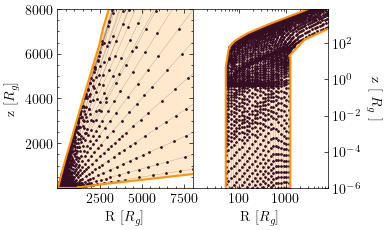

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(mnras_width, mnras_width / 1.5))#, figsize=(4,6))

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, linewidth=0.1, ax=ax[1], color = "#" * hex(convert(RGB, get(cmap, 1))))
#QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,1], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl)

QwindPlotting.plot_streamlines(integ2[1:2:end], fig=fig, ax=ax[2], linewidth=0.1, color = "#" * hex(convert(RGB, get(cmap, 1))))
#QwindPlotting.plot_wind_hull(hull2, fig=fig, ax=ax[2,2], rmax=8000, zmax=8000, nr=500, nz=500, cmap=cmap_pl)

ax[1].set_xlim(10,8000)
ax[1].set_ylim(1e-6, 8000)

ax[2].set_xlim(10,8000)
ax[2].set_ylim(1e-6, 8000)
ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].yaxis.tick_right()


#ax[1,2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2].yaxis.set_label_position("right")

ax[1].set_xticks([2500, 5000, 7500])
ax[1].set_xticklabels([2500, 5000, 7500])

ax[2].set_xticks([1e2, 1000])
ax[2].set_xticklabels([100, 1000])

hull_ps = 10 .^ reduce(hcat, hull2.vertices)
ax[1].plot(hull_ps[1,:], hull_ps[2,:], linewidth=1.5, color = "C2")
ax[1].fill_between(hull_ps[1,:], hull_ps[2,:], alpha=0.2, color = "C2")

ax[2].plot(hull_ps[1,:], hull_ps[2,:], linewidth=1.5, color = "C2")
ax[2].fill_between(hull_ps[1,:], hull_ps[2,:], alpha=0.2, color = "C2")

plt.subplots_adjust(wspace=0, hspace=0)
fig.savefig("plots/wind_hull.pdf", dpi=dpi)

# Density Interpolation Grid

In [25]:
integrators = iterations_dict[2]["integrators"];
r, z, vr, vz, n = Qwind.reduce_integrators(integrators, n_timesteps = 1000)
r0s = [integrator.p.r0 for integrator in integrators]
grid = Qwind.construct_density_grid(r, z, n, r0s, hull2, nr = 500, nz = 500);

┌ Info: Reducing integrators...
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/integrators_interpolator.jl:87
┌ Info: Done
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/integrators_interpolator.jl:105
┌ Info: Constructing density interpolator...
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/density_grid.jl:85
┌ Info: Done
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/density_grid.jl:87
┌ Info: Filling density grid...
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/density_grid.jl:88
┌ Info: Done
└ @ Qwind /home/arnau/code/Qwind.jl/src/radiative_transfer/wind_interpolator/density_grid.jl:108


In [26]:
cmap = colorschemes[:matter]
cmap_pl = ColorMap("cmap", cmap.colors)

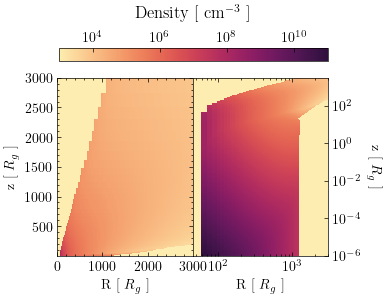

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(mnras_width, 0.7 * mnras_width))

rmax = 3e3
zmax = 3e3

_, _, cm = QwindPlotting.plot_density_grid(grid, fig=fig, ax=ax[1], cmap=cmap_pl, vmin=1e3, vmax=1e11, zmax=zmax, rmax=rmax, nr=250, nz=250, colorbar=false)
QwindPlotting.plot_density_grid(grid, fig=fig, ax=ax[2], cmap=cmap_pl, vmin=1e3, vmax=1e11, zmax=zmax, rmax=rmax, nr=250, nz=250, colorbar=false)

ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")
ax[1].set_xlim(0, rmax)

ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
ax[2].set_yscale("log")
ax[2].set_xscale("log")
ax[2].set_xlim(45, rmax)
ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.13, 0.95, 0.77, 0.05])
cb = fig.colorbar(cm, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_title(L"Density [ cm$^{-3}$ ]", pad=10)

plt.subplots_adjust(wspace=0)

fig.savefig("plots/density_grid.pdf", dpi = dpi)

# X-Ray Grid

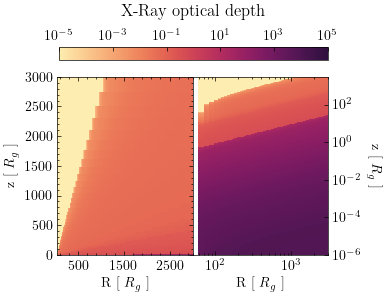

In [28]:
Rg = model.bh.Rg
xl = model.rad.xray_luminosity
density_grid = 
MultipleLocator = matplotlib.ticker.MultipleLocator
ScalarFormatter = matplotlib.ticker.ScalarFormatter 


fig, ax = plt.subplots(1, 2, figsize=(mnras_width, 0.7 * mnras_width))

rmax = 3e3
zmax = 3e3

_, _, cm = QwindPlotting.plot_xray_grid(grid, xl, Rg, fig=fig, ax=ax[1], cmap=cmap_pl, vmin=1e-5, vmax=1e5, nr=250, nz=250, rmax=rmax, zmax=zmax, colorbar=false)
QwindPlotting.plot_xray_grid(grid, xl, Rg, fig=fig, ax=ax[2], cmap=cmap_pl, vmin=1e-5, vmax=1e5, nr=250, nz=250, rmax=rmax, zmax=zmax, colorbar=false)

ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
#ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].set_xlim(50, rmax)
ax[2].set_ylim(1e-6, zmax)
#ax[2].yaxis.set_tick_params(labelright="on", labelleft="off")
#ax[2].yaxis.set_minor_locator(MultipleLocator(1000))
ax[2].yaxis.tick_right()
#ax[2].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].set_ylim(0, zmax)
ax[1].set_xlim(50, rmax)
ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")
ax[1].set_xticks([500, 1500, 2500])

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.13, 0.95, 0.77, 0.05])
cb = fig.colorbar(cm, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_title("X-Ray optical depth", pad=10)

plt.subplots_adjust(wspace=0)
fig.savefig("plots/xray_tau_grid.pdf", dpi=dpi)

# UV Grid

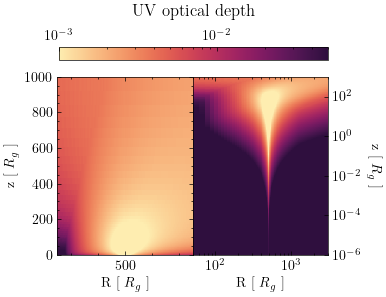

In [29]:
Rg = model.bh.Rg

fig, ax = plt.subplots(1, 2, figsize=(mnras_width, 0.7 * mnras_width))

rmin=1
rmax = 1e3
zmax = 1e3

_, _, cm = QwindPlotting.plot_uv_grid(grid, 500.0, Rg, fig=fig, ax=ax[1], cmap=cmap_pl, vmin=1e-3, vmax=5e-2, nr=250, nz=250, rmin=rmin, rmax=rmax, zmax=zmax, colorbar=false)
QwindPlotting.plot_uv_grid(grid, 500.0, Rg, fig=fig, ax=ax[2], cmap=cmap_pl, vmin=1e-3, vmax=5e-2, nr=250, nz=250, rmin=rmin, rmax=3*rmax, zmax=zmax, colorbar=false)

ax[2].set_xscale("log")
ax[2].set_yscale("log")
ax[2].set_xlabel(L"R [ $R_g$ ]")
ax[2].set_ylabel(L"z [ $R_g$ ]", rotation=-90, labelpad=15)
#ax[2].yaxis.tick_right()
ax[2].yaxis.set_label_position("right")
ax[2].set_xlim(50, 3*rmax)
ax[2].set_ylim(1e-6, zmax)
#ax[2].yaxis.set_tick_params(labelright="on", labelleft="off")
#ax[2].yaxis.set_minor_locator(MultipleLocator(1000))
ax[2].yaxis.tick_right()
#ax[2].yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

ax[1].set_ylim(0, zmax)
ax[1].set_xlim(rmin, rmax)
ax[1].set_xlabel(L"R [ $R_g$ ]")
ax[1].set_ylabel(L"z [ $R_g$ ]")
ax[1].set_xticks([500, 1500, 2500])
ax[1].set_xlim(0, rmax)
ax[1].set_ylim(0, zmax)

fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.13, 0.95, 0.77, 0.05])
cb = fig.colorbar(cm, cax=cbar_ax, orientation="horizontal")
cbar_ax.xaxis.set_ticks_position("top")
cbar_ax.xaxis.set_label_position("top")
cbar_ax.set_title("UV optical depth", pad=10)

plt.subplots_adjust(wspace=0)
fig.savefig("plots/uv_tau_grid.pdf", dpi=dpi)